In [0]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd practical-workshops-reubenbf/

/content/practical-workshops-reubenbf


# Clustering and Text Analysis

The workshop task this week involves unsupervised learning - an exercise in clustering.   We'll use a the Pokemon dataset to walk through the process of kmeans and hierarchical clustering.  We'll then introduce a text dataset for you to experiment with text analysis.

## Pokemon Clustering

The Pokemon dataset that we used in Week 4 is a good example to use for clustering as it has a number of numerical fields giving the properties of each Pokemon.  We can also imagine that there might be different types of Pokemon within the data, so using clustering methods to find the different types is a reasonable approach.  

First we read the data from the CSV file, we'll use the Pokemon name as the data frame index and drop the first column which is a useless index number. 

In [5]:
df = pd.read_csv('data/Pokemon.csv', index_col=1)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Stage,Legendary
Name,,,,,,,,,,,
Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
Ivysaur,Grass,Poison,405,60,62,63,80,80,60,2,False
Venusaur,Grass,Poison,525,80,82,83,100,100,80,3,False
Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
Charmeleon,Fire,NaN,405,58,64,58,80,65,80,2,False


Now you should apply the kMeans clustering method to this data. The first step is to select just the numerical fields in the data.  You can either drop the non-numerical fields or make a new data frame containing just the numerical ones (I suggest making a new data frame).

Then apply the kMeans clustering function to the data, following the steps in the lecture notes and text book.  Since we don't have any real idea how many clusters there could be in the data, start with a small number of clusters (eg. 4) just to make it easier to understand the clusters.

In [0]:
pokemon = df.drop(columns=['Type 1','Type 2','Legendary'])

In [21]:
km = KMeans(n_clusters=2)
km.fit(pokemon)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once you have applied kMeans you will have some results to explore.  Your goal is to understand the clusters that have been produced. If you know something about Pokemon you might be able to recognise similarities between members of each cluster, if not (and even if you do) you need to understand what the members of each cluster have in common. 

The first task is to find out what the members of each cluster are.  To do this, generate a set of cluster labels using `km.predict()` on your original data and add this to the data frame (see the lecture notes).  Now, explore the difference between each cluster:
 
 * find the mean value for each column by cluster, you can do this by selecting the rows for each cluster and then taking the mean or by using the `groupby` method
 * from these means, can you characterise the four clusters that were found, eg. "Cluster 0 are early stage Pokemon with relatively low HP, Attack and Defence ratings".  Provide descriptions like this of each cluster.
 * Identify two columns that seem to be more distinct between clusters, use these to plot the data with different colours for each cluster to visualise the result of clustering.  Comment on the separation of clusters in your plot.
 * Repeat the experiment with a larger number of clusters. Do more clusters make it easier to distinguish the clusters? 

In [0]:
pokemon['label'] = km.predict(pokemon)

In [23]:
pokemean = pokemon.groupby(['label']).agg('mean')
pokemean

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Stage
label,,,,,,,,
0,485.695122,77.304878,86.487805,77.756098,81.560976,80.975610,81.609756,1.914634
1,313.652174,48.652174,55.985507,56.898551,50.000000,48.246377,53.869565,1.188406


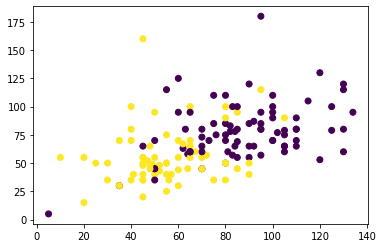

In [24]:
plt.scatter(pokemon['Attack'], pokemon['Defense'], c=pokemon['label'])

### Hierarchical Clustering

Since we don't know how many clusters there should be in the data, a better approach is to use Hierarchical clustering and examine the dendograph to understand what natural clusters are present in the data.  

Apply Hiearchical clustering to the data and plot the dendogram.  From this diagram, how many clusters should the data be separated into?   Can you characterise these clusters? 

In [0]:
dist = pdist(pokemon, 'euclidean')
linkage_matrix = linkage(dist,method = 'complete')

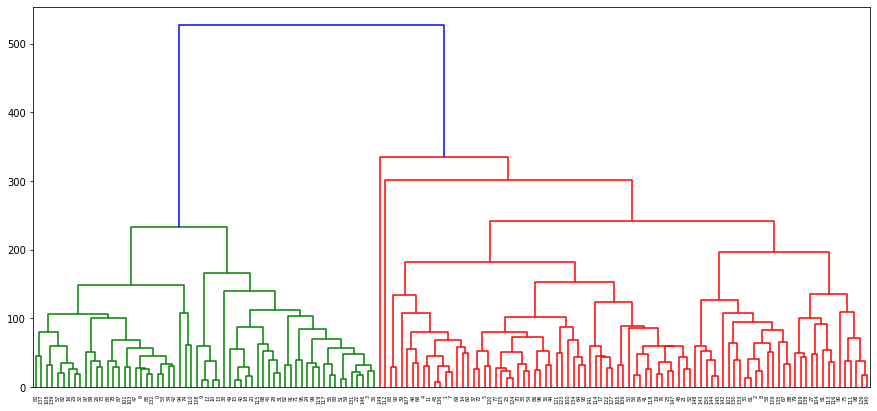

In [49]:
plt.figure(figsize=(15,7))
dendrogram(linkage_matrix)
plt.show()

In [44]:
labels = cut_tree(linkage_matrix, n_clusters=3)
pokemon['label'] = labels

pokemon[pokemon['label']==0]



,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Stage,label
Name,,,,,,,,,
Bulbasaur,318,45,49,49,65,65,45,1,0
Charmander,309,39,52,43,60,50,65,1,0
Squirtle,314,44,48,65,50,64,43,1,0
Caterpie,195,45,30,35,20,20,45,1,0
Metapod,205,50,20,55,25,25,30,2,0
...,...,...,...,...,...,...,...,...,...
Ditto,288,48,48,48,48,48,48,1,0
Eevee,325,55,55,50,45,65,55,1,0
Omanyte,355,35,40,100,90,55,35,1,0


## Text Analysis

Text is an important data source and in the lecture we looked at how to use word vectors to create features from text. We can use this method to derive a numerical vector from each text and then perform clustering on the texts.  

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) but we'll work with just the first 100 books which usefully include some of the 'books' from the Bible which we might expect to form a cluster different to the other texts.  

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](files/booksummaries/README.txt) file.

In [27]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries.txt", sep="\t", header=None, names=names)

# select just the first 100 books
books = books[:100]

books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


To analyse the text, you first need to compute the numerical features. To do this, use the `TfidfVectorizer` from the sklearn library (this is already imported at the top of this notebook) following the method used in the lecture.  Use a small number of features (word) in your vectorizer (eg. 50-100) just to simplify understanding the process.  

Once you have done this you can apply the clustering methods to this data just as you did above for the Pokemon data. Use the same approach to cluster these 100 books and understand the clusters you find. Note, the features you have now will be word TFIDF scores and you probably have 50-100 of them making it harder to understand the clusters numerically. So, you will have to look at the book titles, authors and publication dates to see if you can understand what clusters have been formed. In particular, look to see if the Bible books have been put into the same cluster distinct from the other texts. 

In [0]:
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(books.summary).toarray()

In [37]:
print(vectorizer.get_feature_names())

['about', 'after', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'for', 'from', 'god', 'had', 'has', 'have', 'he', 'her', 'him', 'his', 'in', 'into', 'is', 'it', 'not', 'of', 'on', 'one', 'or', 'out', 'she', 'that', 'the', 'their', 'them', 'then', 'they', 'this', 'to', 'two', 'up', 'was', 'when', 'where', 'which', 'who', 'will', 'with']


In [0]:
dist = pdist(X, 'euclidean')
linkage_matrix = linkage(dist, method = 'ward')  # or 'complete'

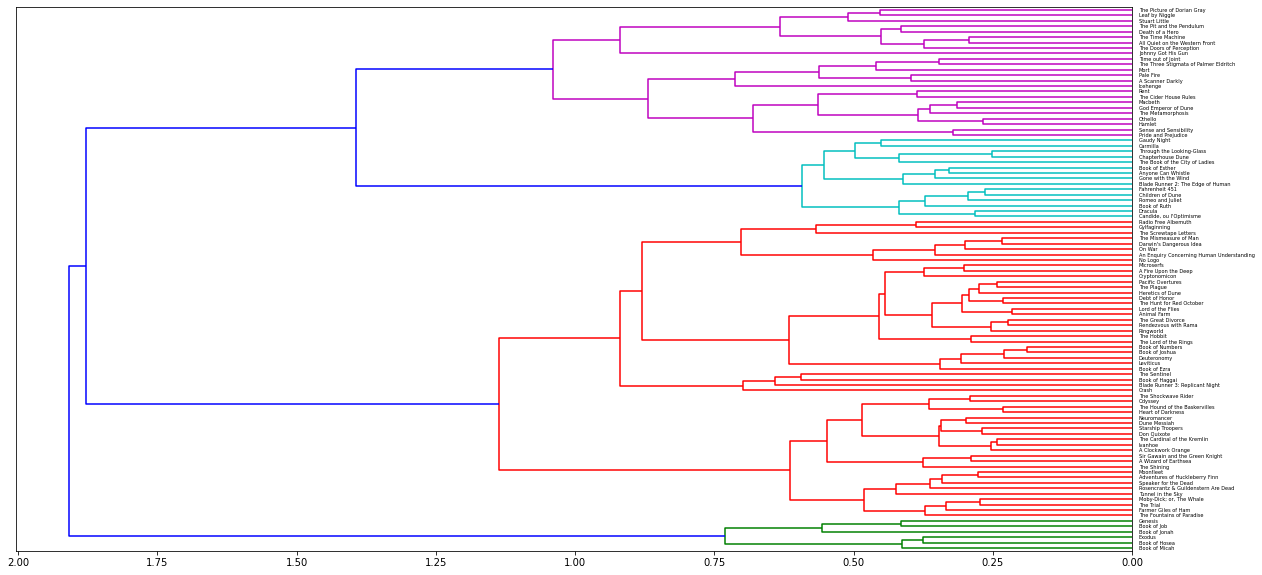

In [46]:
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix, labels=list(books.title), orientation='left')
plt.show()

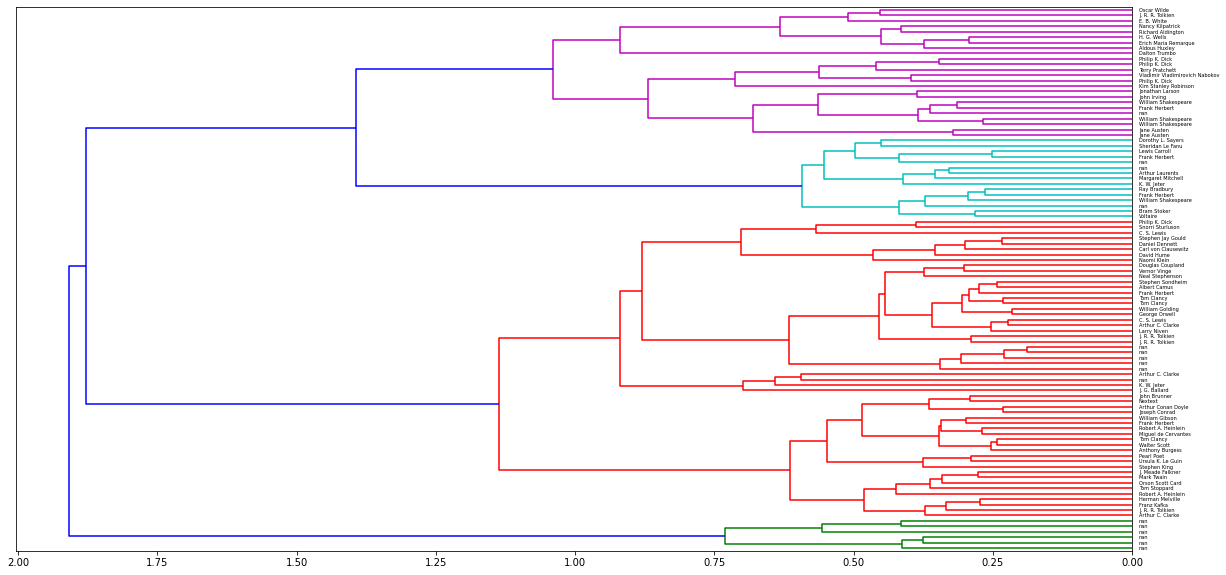

In [47]:
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix, labels=list(books.author), orientation='left')
plt.show()

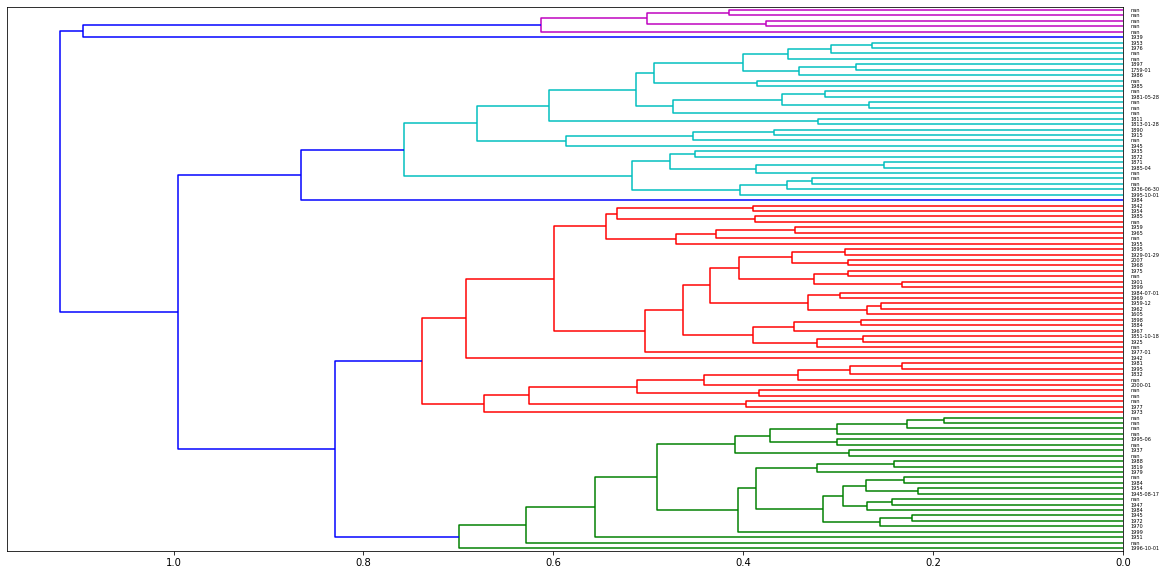

In [40]:
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix, labels=list(books.date), orientation='left')
plt.show()